In [1]:
% setup MRI-education-resources path and requirements
cd ../
startup

loading image
loading signal


# RF Pulses

The purpose of appling RF magnetic fields is to excite the spins.  Equivalently, this RF energy aims to flip the net magnetization.
This RF energy is referred to as an RF pulse, since the RF energy is applied for a short period of time and then switched off.

## Learning Goals

1. Describe how various types of MRI contrast are created
    * Understand how changes in flip angle are implemented
1. Manipulate MRI sequence parameters to improve performance
    * Understand how changes in flip angle are implemented
1. Describe how images are formed
    * Describe how RF pulses are frequency-selective

## How RF Pulses are Used in MRI

Fundamentally, RF pulses are used to flip the net magnetization.  This creates signal and also manipultes contrast.  Also, applying magnetic field gradients during an RF pulse will create slice selection.

## Types of RF Pulses

| Pulse Type      | Purpose                | Magnetization Effect   | Flip Angle      |
|-----------------|------------------------|-----------------|-------------------------|
| Excitation       | Create signal             | $M_Z$ to $M_{XY}$     | up to 90-degrees |
| Inversion        | Enhance contrast    | $M_Z$ to -$M_Z$            | 180-degrees         |
| Refocusing        | Create spin-echoes      | $M_{XY}$ to $M_{XY}$ | 180-degrees         |
| Saturation       | Suppress magnetization | $M_Z$ to 0 | 90-degrees         |



## RF Pulse Properties

Here is a summary of RF pulse properties and parameters that are important for MRI.  These will be explained in detail later.

![RF Pulse Parameters](images/RF_Pulses-pulse_parameters.png)

### Flip Angle

The flip angle (on-resonance) is equal to the integral of the RF pulse shape, $b_1(t)$ (in units of magnetic field)):

$$\theta = \gamma \int_0^{T_{rf}} b_1(\tau) d\tau $$

### Time-bandwidth Product

The time-bandwidth product (TBW) characterizes the relationship between pulse duration, $T_{rf}$, and bandwidth, $BW_{rf}$ and is a fixed value for a given pulse shape. It is defined as

$$ TBW_{rf} = T_{rf} \cdot BW_{rf} $$

For a sinc or sinc-like pulse, the TBW product is equal to the number of zero-crossings in the pulse shape.

### Specific Absorption Rate

The Specific Absorption Rate (SAR) measures the amount of energy absorbed by the body from a RF pulse.  Since this absorption can cause tissue heating there are safety limits on SAR.  It is proportional to the integrated total RF pulse power:

$$ SAR \propto \int_0^{T_{rf}} |b_1(\tau)|^2 d\tau $$

$T_{rf}$ is the duration of the RF pulse.
  For for MRI, SAR can cause tissue heating and thus there are SAR safety limits to minimize this heating.

## Hard pulse versus Shaped Pulse

The first RF pulse typically introduced in MRI education is the so-called "hard" pulse - a constant amplitude pulse applied for some period of time.  As will be shown below, this pulse performs poorly for slice-selection, so shaped sinc-like pulses are used.  Shaped pulses create frequency profiles that excite a range of frequencies approximately uniformly (with the same flip angle), while not exciting spins outside this frequency range.


### On-resonance Excitation
We can visualize the rotation of the net magnetization as before as a rotation about the RF pulse vector, for Hard and Shaped pulses:

**hard pulse:**

![Hard Pulse on resonance](images/hard_pulse_center_frequency.gif)

**shaped pulse:**

![Shaped pulse on resonance](images/sinc_pulse_center_frequency.gif)

Looking at the on-resonance or center frequency response of a sinc-like shaped pulse, the flip angle is achieved slightly differently by tipping the net magnetization back and forth.

### Off-resonance Excitation

The flip angle provided by a hard pulse varies substantially as a function of off-resonance frequency (e.g. in the presence of a magnetic field gradient) so is not a good pulse for slice-selection.  Meanwhile, the sinc-like pulse becomes advantageous when considering a range of resonance frequencies, where this pattern of back and forth tipping leads to net magnetizations either being flipped or not:


This is illustrated by the following animation, showing net magnetizations across a range of positions when the pulse is applied with a gradient:

**hard pulse:**

![Hard pulse off resonance](images/hard_pulse_frequencies.gif)

**shaped pulse:**

![Sinc pulse off resonance](images/sinc_pulse_frequencies.gif)

These simulations are for an identical range of positions, allowing for visualization the majority of net magnetizations in this case are either at an approximate 90-degree or 0-degree excitation, with very few intermediate flip angles. that the range of resulting magnetizations from the *hard pulse* is wide, representing a spread of different flip angles at  different positions, whereas with the sinc-like pulse  the majority of net magnetizations in this case are either at an approximate 90-degree or 0-degree excitation, with very few intermediate flip angles. (Also note the refocusing gradient at the end, which is necessary for corrected for additional phase during the gradient & RF.)

This behavior can be analyzed by simulation of the RF pulse profile as well, now using the Bloch equation for a more precise simulation as compared to using Fourier Transform approximation:


## RF Pulse Profile

To precisely characterize the behavior of an RF pulse, a pulse profile can be computed.  

In this section, we will characterize the behavior of RF pulses as a function of off-resonance, or frequency.  In the next section, gradients will be added to perform slice selection and the profile will be computed as a function of space.

The RF pulse profile can plot several parameters, including the flip angle, the resulting transverse magnetization $M_{XY}$, and the resulting longitudinal magnetization $M_Z$.

The following simulations compute the magnetization profiles after hard and shaped RF pulses.

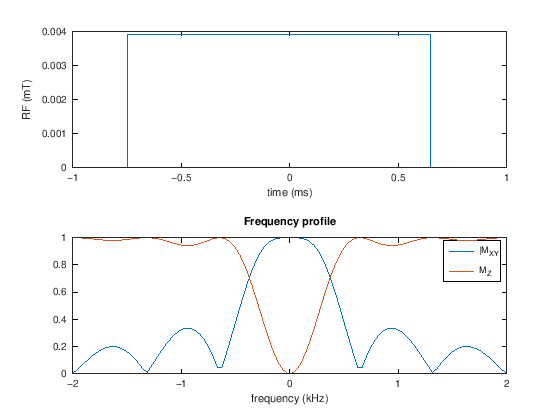

In [ ]:
gammabar = 42.58; % kHz/mT

M0 = 1;
M_equilibrium = [0,0,M0].';
dt = 0.1; % ms

flip = 90;

% Hard Pulse
tmax = 1.5;
N = tmax/dt;
t = [-N/2:N/2-1]*dt;
RF = ones(1,N);
RF = (flip*pi/180)* RF/sum(RF) /(2*pi*gammabar*dt);

% B10 = (flip/360) / (gammabar*length(RF)*dt)


BW = 2; % kHz
df = linspace(-BW,BW);

M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end

subplot(211)
plot([t(1)-eps,t,t(end)+eps],[0,RF,0])
xlabel('time (ms)'), ylabel('RF (mT)')
subplot(212)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'), legend('|M_{XY}|', 'M_Z')%, ylabel('flip')

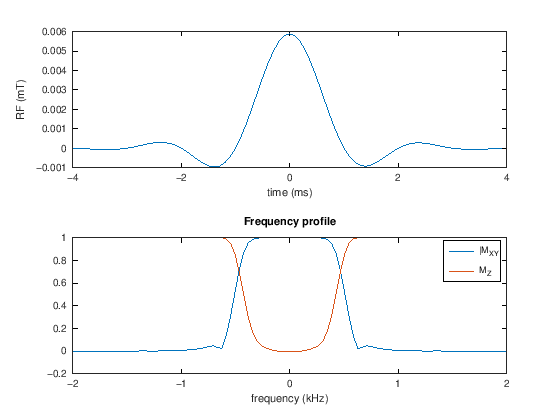

In [ ]:
% Windowed Sinc Pulse
tmax = 8;
N = tmax/dt;
t = [-N/2:N/2-1]*dt;
RF =  hamming(N)' .* sinc(t);
RF = (flip*pi/180)* RF/sum(RF) /(2*pi*gammabar*dt);


M = repmat(M_equilibrium, [1, length(df)]);
for n = 1:length(t)
    for f = 1:length(df)
        M(:,f) = bloch_rotate( M(:,f), dt, [real(RF(n)),imag(RF(n)),df(f)/gammabar]);
    end
end


subplot(211)
plot(t,RF)
xlabel('time (ms)'), ylabel('RF (mT)')
subplot(212)
plot(df,sqrt(M(1,:).^2 + M(2,:).^2), df, M(3,:))
title('Frequency profile')
xlabel('frequency (kHz)'), legend('|M_{XY}|', 'M_Z')%, ylabel('flip')

## Frequency Content in RF Pulses

For RF pulses, we generally want to control the frequencies that are excited.  Most commonly, we want to excite a range of frequencies that then will correspond to a range of positions to excite a slice.

### Sum of Frequencies

One way to think of the RF pulse design then, is that we can add a range of frequencies together in the RF pulse, which will then excite a range of off-resonance frequencies.
This "sum of frequencies" illustration of RF pulses is shown in the following animations.

In the lab frame, this happens around the Larmor frequency:

![RF_pulse_frequencies-lab_frame.gif](images/RF_pulse_frequencies-lab_frame.gif)

In the rotating frame, the frequencies build up around frequency = 0

![RF_pulse_frequencies-rotating_frame.gif](images/RF_pulse_frequencies-rotating_frame.gif)

### Fourier Transform Approximation

Based on the above illustration, we can see that the profile of an RF pulse is similar to a Fourier Transform - an operation that determines the frequency content of a signal.  
In practice, the RF pulse profile is only approximately proportional to the Fourier Transform of the RF pulse shape, but this approximation is useful for understanding the frequency content of RF pulses.

$$\theta(f) \approx \gamma \mathcal{F}\{b_1(t)\}$$

where $b_1(t)$ is the RF pulse shape, and $\theta(f)$ is the flip angle at frequency $f$.

For this reason, our typical RF pulse shapes are sinc-like, which have a Fourier Transform that are rect-like.
In practice, this approximation is only valid for small flip angles, typically up to 60 degrees.  There are tools such as the SLR transform that can be used to design RF pulses with larger flip angles, which are described later.

![RF pulse profiles is small and large flip angles, computed with Bloch equation and Fourier Transform approximation](images/RF_Pulses-small_large_tip_example.png)



## Frequency-Selective Pulses for Fat Suppression

Fat is often a nuisance signal in MRI.  We can use frequency-selective RF pulses for fat suppression by applying a saturation pulse that tips fat 90-degrees but tips water 0-degrees.  This can be done based on the chemical shift between fat and water, and by using a frequency-selective RF pulse as described above.   At this point, $M_{Z,fat} = 0$ but $M_{Z,water}$ is unaffected.
This pulse is followed by a spoiler gradient which will dephase the transverse magnetization of fat, resulting in no signal from fat, $m_{fat} = 0$.

Frequency-selective inversion pulses can also be used for fat suppression along with inversion recovery.  The inversion pulse tips fat 190-degrees but tips water 0-degrees, and is followed by an inversion time to null fat based on its $T_1$.